# Modules, colors, and functions

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
  return false;
}

<IPython.core.display.Javascript object>

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/tmp/ipykernel_3919/3777615979.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [3]:
# Modules
import scipy as sp
from scipy import signal
from astropy import convolution as conv
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as clrs
import pandas as pd 
import datetime

%matplotlib inline 

from utils.detect_peaks import detect_peaks


# Color definitions
ClrS = (0.74, 0.00, 0.00)
ClrN = (0.20, 0.56, 1.00)

Clr = [(0.00, 0.00, 0.00),
      (0.31, 0.24, 0.00),
      (0.43, 0.16, 0.49),
      (0.32, 0.70, 0.30),
      (0.45, 0.70, 0.90),
      (1.00, 0.82, 0.67)]

# Font Size

font = {'family': 'sans-serif',
        'weight': 'normal',
        'size'   : 21}

plt.rc('font', **font)

# Histogram and scatter plot
def plotHistSqrtSSN(ax, calRefT, calObsT, Th, maxN, SqrtF):
    
    # Number of bins to use
    Nbins = maxN
    
    #Edges and Centers
    edges = np.arange(0,np.ceil(maxN)+np.round(maxN*0.25), (np.ceil(maxN))/Nbins) - (np.ceil(maxN))/Nbins/2
    centers = (edges[1:edges.shape[0]] + edges[0:edges.shape[0]-1])/2    
    
    # Applying Sqrt + 1
    if SqrtF:        
        maxN = np.sqrt(maxN)
        calRefT = np.sqrt(calRefT+1)
        calObsT = np.sqrt(calObsT+1)
        
        #Edges and Centers
        edges = np.arange(1,np.ceil(maxN)*1.05, (np.ceil(maxN))/Nbins) - (np.ceil(maxN))/Nbins/2
        centers = (edges[1:edges.shape[0]] + edges[0:edges.shape[0]-1])/2 
    
    # Average group number 
    ax.hist2d(calObsT, calRefT, bins=edges, cmap=plt.cm.magma_r,cmin=1)
    
    hist, xedges, yedges = np.histogram2d(calObsT, calRefT, bins=edges)
    alphaY = np.sum(hist,axis=1)/np.max(np.sum(hist,axis=1))*0.95+0.05
    
    # Calculating Quantities for plot and plot centers in Y
    Ymedian = centers*np.nan
    for i in range(0, centers.shape[0]):
        ypoints = calRefT[np.logical_and(calObsT>=edges[i], calObsT<=edges[i+1])]
        if ypoints.shape[0]>0:
            Ymedian[i] = np.nanmedian(ypoints)
            pecentilesy = np.abs(np.percentile(ypoints,np.array([15,85]), interpolation = 'linear')-Ymedian[i])
        
            xpoints = calObsT[np.logical_and(calRefT>=(Ymedian[i]-(np.ceil(maxN))/Nbins/2), calRefT<=(Ymedian[i]+(np.ceil(maxN))/Nbins/2))]
        
            if xpoints.shape[0]>0:
                pecentilesx = np.abs(np.percentile(xpoints,np.array([15,85]), interpolation = 'linear')-centers[i])
            else:
                pecentilesx = pecentilesy*0
        
            ax.errorbar(centers[i], Ymedian[i], yerr = np.expand_dims(pecentilesy,axis = 1), xerr = np.expand_dims(pecentilesx,axis = 1), color='k', zorder=11, alpha=alphaY[i])
            ax.scatter(centers[i], Ymedian[i], color='w', edgecolor='k', s=100, linewidths = 3, zorder=11, alpha=alphaY[i])

    # Calculating quantities for assessment
    y = Ymedian
    x = centers

    x = x[np.isfinite(y)]
    y = y[np.isfinite(y)]

    # R squared
    yMean = np.mean(y)    
    SStot = np.sum(np.power(y-yMean,2)) 
    SSreg = np.sum(np.power(y-x,2))
    rSq   = (1 - SSreg/SStot)

    # Mean Residual
    mRes = np.mean(y-x)
    
    # Mean Relative Residual
    mRRes = np.mean(np.divide(y[x>0]-x[x>0],x[x>0]))    
    
    ax.plot(edges, edges, '--'
             , color = Clr[4], linewidth = 3)

    ax.text(0.5, 0.95,'$R^2M$=' + str(np.round(rSq,decimals=2)) + ' $MR$=' + str(np.round(mRes,decimals=2)) + ' $MRR$=' + str(int(np.round(mRRes*100,decimals=0))) + '% $Th$=' + str(Th), horizontalalignment='center', verticalalignment='center',transform=ax.transAxes)

    # Axes properties
    
    if SqrtF: 
        ax.set_xlabel('sqrt(GN+1) for ' + NamObs.capitalize())
        ax.set_ylabel('sqrt(GN+1) for reference')
    else:
        ax.set_xlabel('GN for ' + NamObs.capitalize())
        ax.set_ylabel('GN for reference observer')
        
    ax.set_xticks(np.arange(centers[0],np.ceil(centers[-1]), np.floor((np.ceil(centers[-1])-centers[0])/8)+1 ))
    ax.set_yticks(np.arange(centers[0],np.ceil(centers[-1]), np.floor((np.ceil(centers[-1])-centers[0])/8)+1 ))

        
# Histogram Outline
def histOutline(dataIn, *args, **kwargs):
    (histIn, binsIn) = np.histogram(dataIn, *args, **kwargs)

    stepSize = binsIn[1] - binsIn[0]

    bins = np.zeros(len(binsIn)*2 + 2, dtype=np.float)
    data = np.zeros(len(binsIn)*2 + 2, dtype=np.float)
    for bb in range(len(binsIn)):
        bins[2*bb + 1] = binsIn[bb]
        bins[2*bb + 2] = binsIn[bb] + stepSize
        if bb < len(histIn):
            data[2*bb + 1] = histIn[bb]
            data[2*bb + 2] = histIn[bb]

    bins[0] = bins[1]
    bins[-1] = bins[-2]
    data[0] = 0
    data[-1] = 0

    return (bins, data)

<frozen importlib._bootstrap>:241: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 88 from C header, got 96 from PyObject


# Reading Reference data

We use a reduced version of the RGO and Debrecen data as provided by the [Heliophysical Observatory, Debrecen
](http://fenyi.solarobs.csfk.mta.hu/en/databases/GPR/).  Supplemented during cycle 24 with observations by the [Kidslovodsk Mountain Astronomical Station](http://dx.doi.org/10.7910/DVN/M7NDXN).  It has been recast as a table where each corresponds to a single day and the areas of each group for a given day are stored as columns.

We add two more columns to the data:
    1. ORDINAL:  number of days after (0001,01,01).
    2. FRACYEAR: Fractional year for plotting.

In [9]:
REF_Dat = pd.read_csv('data/SC_SP_RG_DB_KM_group_areas_by_day.csv', quotechar = '"',header = 0)
# Remove Years before 1902
# REF_Dat = REF_Dat[REF_Dat['YEAR']>1900]
REF_Dat['ORDINAL'] = REF_Dat.apply(lambda x: datetime.date(x['YEAR'].astype(int),x['MONTH'].astype(int),x['DAY'].astype(int)).toordinal(),axis=1)
REF_Dat['FRACYEAR'] = REF_Dat.apply(lambda x: x['YEAR'].astype(int)
                                        + (  datetime.date(x['YEAR'].astype(int),x['MONTH'].astype(int),x['DAY'].astype(int)).toordinal()
                                           - datetime.date(x['YEAR'].astype(int),1,1).toordinal() )
                                        / (  datetime.date(x['YEAR'].astype(int)+1,1,1).toordinal()
                                           - datetime.date(x['YEAR'].astype(int),1,1).toordinal() )
                              ,axis=1)





# Turning reference areas into number of groups
REF_Grp = REF_Dat[['FRACYEAR','ORDINAL','YEAR','MONTH','DAY']].copy()
REF_Grp['GROUPS'] = np.nansum( np.greater(REF_Dat.values[:,3:REF_Dat.values.shape[1]-2],0) ,axis = 1)
REF_Grp['GROUPS'] = REF_Grp['GROUPS'].astype(float)
REF_Grp.loc[np.isnan(REF_Dat['AREA1']), 'GROUPS'] = np.nan

# Smoothing for plotting
Gss_1D_ker = conv.Gaussian1DKernel(75)
REF_Grp['AVGROUPS']  = conv.convolve(REF_Grp['GROUPS'].values,Gss_1D_ker)

REF_Dat

,YEAR,MONTH,DAY,AREA1,AREA2,AREA3,AREA4,AREA5,AREA6,AREA7,...,AREA19,AREA20,AREA21,AREA22,AREA23,AREA24,AREA25,AREA26,ORDINAL,FRACYEAR
0,1825,11,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,666511,1825.843836
1,1825,11,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,666512,1825.846575
2,1825,11,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,666513,1825.849315
3,1825,11,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,666514,1825.852055
4,1825,11,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,666515,1825.854795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70349,2018,6,15,54.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,736860,2018.452055
70350,2018,6,16,64.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,736861,2018.454795
70351,2018,6,17,54.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,736862,2018.457534
70352,2018,6,18,74.0,22.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,736863,2018.460274


# Reading SILSO's total sunspot number

We use the current series to separate individual cycles from minimum to minimum.  We also identify all the minima present in the reference data, removing the first two minima to isolate potential drifts and systematic errors during the beginning of the RGO era.

In [13]:
SILSO_Sn = pd.read_csv('data/SN_m_tot_V2.0.csv', quotechar = '"', header=0)
SILSO_Sn_d = pd.read_csv('data/SN_d_tot_V2.0.csv', quotechar = '"', header=0)

# Including daily value and interpolating
SILSO_Sn_d['MONTHSN']=SILSO_Sn_d['DAILYSN']
SILSO_Sn_d.loc[SILSO_Sn_d['DAILYSN']<0,'MONTHSN'] = interp(SILSO_Sn_d.loc[SILSO_Sn_d['DAILYSN']<0,'FRACYEAR'],
                                                              SILSO_Sn_d.loc[SILSO_Sn_d['DAILYSN']>=0,'FRACYEAR'],
                                                              SILSO_Sn_d.loc[SILSO_Sn_d['DAILYSN']>=0,'DAILYSN'])
SILSO_Sn_d['DAILYSN'] = SILSO_Sn_d['DAILYSN'].astype(float)


# Smoothing for plotting
Gss_1D_ker = conv.Gaussian1DKernel(365)
SILSO_Sn_d['AVGSNd']  = conv.convolve(SILSO_Sn_d['DAILYSN'].values,Gss_1D_ker)

# Smoothing
swin = 8 #Smoothing window in months
window = signal.gaussian(M=swin*6, std=swin)
window /= window.sum()

SILSO_Sn['MSMOOTH'] = np.convolve(SILSO_Sn['MMEAN'], window, mode='same')

# Finding maxima and minima
pkMax = detect_peaks(SILSO_Sn['MSMOOTH'], mpd=5)
pkMin = detect_peaks(-SILSO_Sn['MSMOOTH'], mpd=5)

SIL_max = SILSO_Sn.loc[pkMax, 'MSMOOTH'].values
SIL_maxT = SILSO_Sn.loc[pkMax, 'FRACYEAR'].values

SIL_min = SILSO_Sn.loc[pkMin, 'MSMOOTH'].values
SIL_minT = SILSO_Sn.loc[pkMin, 'FRACYEAR'].values

# Identify minima covered by the reference data
REF_min = SIL_min[np.logical_and(SIL_minT<=np.max(REF_Dat['FRACYEAR']), SIL_minT>=np.min(REF_Dat['FRACYEAR']))]
REF_minT = SIL_minT[np.logical_and(SIL_minT<=np.max(REF_Dat['FRACYEAR']), SIL_minT>=np.min(REF_Dat['FRACYEAR']))]

# Identify axima covered by the reference data
REF_max = SIL_max[np.logical_and(SIL_maxT<=np.max(REF_Dat['FRACYEAR']), SIL_maxT>=np.min(REF_Dat['FRACYEAR']))]
REF_maxT = SIL_maxT[np.logical_and(SIL_maxT<=np.max(REF_Dat['FRACYEAR']), SIL_maxT>=np.min(REF_Dat['FRACYEAR']))]


# Reading observations and observers

The files used were downloaded from [SILSO's Group Number page](http://www.sidc.be/silso/groupnumberv3).  The current version used is JV_V1-12, but turned into a .csv file.  The original file contains leap years that should not be there.  February 29th for those years were removed by hand (1700, 1800, 1900).

## Reading observations

We recast the number of groups as a float so that we can use NaNs for days with missing observations.

In [17]:
GN_Dat = pd.read_csv('data/GNobservations_JV_V1.22.csv', quotechar = '"',header = 15)
GN_Dat['GROUPS'] = GN_Dat['GROUPS'].astype(float)

## Reading observers

We create a variable to store each unique observer.  **NOTE THAT CURRENTLY EACH STATION HAS _ONLY_ ONE OBSERVER SO WE DO ALL OUR LOGICAL OPERATIONS USING THE 'STATION' FIELD**.

We also remove the '0' station which indicates a day without observations.

The **_print_** statement on this cell can be use for reference as it shows the station number associated with each observer.

In [20]:
GN_Obs = pd.read_csv('data/GNobservers_JV_V1.22.csv', quotechar = '"')
print(GN_Obs[['INITIAL','FINAL','STATION','OBSERVER','TOT.OBS']].to_string())

UnObs = np.unique(GN_Dat.STATION)
UnObs = UnObs[UnObs>0]

     INITIAL   FINAL  STATION                                   OBSERVER  TOT.OBS
0     1610.0  1613.0        1                        HARRIOT, T., OXFORD      210
1     1611.0  1640.0        2                         SCHEINER, C., ROME      882
2     1612.0  1612.0        3                          GALILEO, G., ROME       51
3     1612.0  1612.0        4                      GALILEO-SAKURAI, ROME       37
4     1612.0  1612.0        5                      COLOGNA, S., MONREALE       20
5     1612.0  1613.0        6                       JUNGIUS, J., HAMBURG      104
6     1612.0  1612.0        7                         CIGOLI, L.C., ROME       29
7     1613.0  1614.0        8                        COLONNA, F., NAPLES       51
8     1615.0  1617.0        9                          TARDE, J., FARLAT       57
9     1616.0  1616.0       10                    SAXONIUS, P., NUREMBERG       12
10       NaN     NaN       11                      MARIUS, S., NUREMBERG        0
11    1618.0  16

<a id='observer'></a>
# Processing observer

This cell picks the observer that will be calibrated to REF.  Some interesting observers are:

* Spörer: 318 (lots of missing zeros)
* Leppig: 324 (short and consistent, but with lots of missing days)
* Wolfer: 338 (long and dense)

It is interesting to see if the time optimization can get the proper time accurately.  Some observers that do:

* Moye: 412 (1 cycle)
* Broger: 370 (4 cycles)

Some that don't

* Woinoff: 376 (2 cycles, very strong yearly variation)

Other long observers with overlap are:

* Sykora: 366
* Guillaume: 386
* Stempell: 389 (lots of gaps)
* Koyama: 445
* National astron. ob. Japan: 447

Observations for the chosen observer are filled with NaNs for days without observations.


In [23]:
# Observer Station Number
CalObs = 614
NamObs = GN_Obs['OBSERVER'].values[GN_Obs['STATION'].values==CalObs]
NamObs = NamObs[0]
NamObs = NamObs[0:NamObs.find(',')]

#print(NamObs)

# Picking observations
ObsDat = GN_Dat[GN_Dat.STATION == CalObs].copy()

# Finding missing days
ObsInt  = np.arange(np.min(ObsDat['ORDINAL']), np.max(ObsDat['ORDINAL']+1))
MisDays =  np.logical_not(np.in1d(ObsInt, ObsDat['ORDINAL'] ))

# Creating dataframe with NaNs for days without observations
year  = np.array(list(map(lambda x: datetime.date.fromordinal(x).year, ObsInt[MisDays])))
month = np.array(list(map(lambda x: datetime.date.fromordinal(x).month, ObsInt[MisDays])))
day   = np.array(list(map(lambda x: datetime.date.fromordinal(x).day, ObsInt[MisDays])))

station  = day*0+CalObs
observer = day*0+1
groups   = day*np.nan

fractyear = np.array(list(map(lambda year, month, day : year + (  datetime.date(year, month , day).toordinal()
                                            - datetime.date(year,1,1).toordinal() )
                                            / (  datetime.date(year+1,1,1).toordinal()
                                            - datetime.date(year,1,1).toordinal() ), year, month, day)))

NoObs = pd.DataFrame(np.column_stack((year, month, day, ObsInt[MisDays], station, observer, groups, fractyear)), columns = ObsDat.columns.values)

# Append dataframe with missing days
ObsDat = pd.concat([ObsDat,NoObs], ignore_index=True)

# Recast using original data types
origType = GN_Dat.dtypes.to_dict()
ObsDat = ObsDat.apply(lambda x: x.astype(origType[x.name]))

# Sorting according to date
ObsDat = ObsDat.sort_values('ORDINAL').reset_index(drop=True)

In [24]:
# Final data for RGO and given observer
cond1=pd.merge(SILSO_Sn_d, ObsDat, on=['YEAR', 'MONTH', 'DAY'], how='inner')
cond2=pd.merge(SILSO_Sn_d, REF_Grp, on=['YEAR', 'MONTH', 'DAY'], how='inner')
print(cond1)

ObsDat=ObsDat.join(cond1['AVGSNd'])
REF_Grp=REF_Grp.join(cond2['AVGSNd'])
print(ObsDat)
print(REF_Grp)

       YEAR  MONTH  DAY  FRACYEAR_x  DAILYSN  DAILYSTD  NOBS  MARKER  MONTHSN  \
0      1958      1    1    1958.001    303.0      11.7     1       1    303.0   
1      1958      1    2    1958.004    302.0      11.6     1       1    302.0   
2      1958      1    3    1958.007    283.0      11.3     1       1    283.0   
3      1958      1    4    1958.010    307.0      11.7     1       1    307.0   
4      1958      1    5    1958.012    270.0      11.0     1       1    270.0   
...     ...    ...  ...         ...      ...       ...   ...     ...      ...   
19353  2010     12   27    2010.988     17.0       2.2    13       1     17.0   
19354  2010     12   28    2010.990     22.0       1.9    12       1     22.0   
19355  2010     12   29    2010.993     19.0       1.5    15       1     19.0   
19356  2010     12   30    2010.996     14.0       2.8     9       1     14.0   
19357  2010     12   31    2010.999     42.0       3.2    10       1     42.0   

           AVGSNd  ORDINAL 

<a id='duration'></a>
## Recasting observations into equal intervals of specified duration


To simplify and speedup the analysis we segment the observational interval using "months" of arbitrary length. This allows us to reshape our time series into a matrix and perform matrix-vector operations that are much faster than for loops.

Only an integer amount of "months" is used in order to make the reshaping operation possible.

In [26]:
# Number of days per "month"
MoLngt = 15

# OBSERVER
# Selecting the maximum integer amount of "months" out of the original data
grpsOb = ObsDat['GROUPS'].values
grpsOb = grpsOb[0:int(grpsOb.shape[0]/MoLngt)*MoLngt]

ordOb = ObsDat['ORDINAL'].values
ordOb = ordOb[0:int(ordOb.shape[0]/MoLngt)*MoLngt]

yrOb = ObsDat['FRACYEAR'].values
yrOb = yrOb[0:int(yrOb.shape[0]/MoLngt)*MoLngt]

# Reshaping
grpsOb = grpsOb.reshape((-1,MoLngt))
ordOb  = ordOb.reshape((-1,MoLngt))
yrOb   = yrOb.reshape((-1,MoLngt))

<a id='coverage'></a>
## Calculating number of days with observations and number of days with groups 

In [27]:
# OBSERVER

# Minimum fraction of observed days for an interval to be considered useful
minObD = 0.33

# Number of days with observations
obsOb = np.sum(np.isfinite(grpsOb),axis=1)

# Number of days with groups
grpOb = np.sum(np.greater(grpsOb,0),axis=1)

# Average number of groups
Gss_1D_ker = conv.Gaussian1DKernel(2)
AvGrpOb = conv.convolve(np.nanmean(grpsOb,axis=1),Gss_1D_ker)
SdGrpOb = np.nanstd(grpsOb,axis=1)

# Interval edges for plotting
fyr1Ob = np.min(yrOb,axis=1)
fyr2Ob = np.max(yrOb,axis=1)

/tmp/ipykernel_3919/3667639623.py:14: RuntimeWarning: Mean of empty slice
  AvGrpOb = conv.convolve(np.nanmean(grpsOb,axis=1),Gss_1D_ker)
/home/amunozj/anaconda3/envs/pyro/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


<a id='#subintervals'></a>
## Breaking Observer Period into rising (decaying) Intervals

We break the observational period into cycles going from minimum to maximum, and maximum to minumum, in order to ease the capability of the algorithm to find the best matches during the reference era.

In [32]:
# Minimum number of months with ADF greater than 0 and lower than 1 for interval to be considered valid        
minADFmnth = 5

# Maximum number of valid intervals to use
maxValInt = 3

# Finding internal endpoints and centers of SILSO

# Assinging max (1) and min (-1) labels to endpoints
maxPointsS = np.expand_dims(SIL_maxT,1)
maxPointsS = np.concatenate((maxPointsS,maxPointsS*0+1),axis=1)

minPointsS = np.expand_dims(SIL_minT,1)
minPointsS = np.concatenate((minPointsS,minPointsS*0-1),axis=1)

# Creating endpoints matrix
endPointsS = np.append(maxPointsS,minPointsS,axis=0)

# Sorting endpoints
endPointsS = endPointsS[endPointsS[:,0].argsort()]

# Finding centers and classifying them as rising (1) and decaying (-1)
cenPointsS = (endPointsS[1:endPointsS.shape[0],:]+endPointsS[0:endPointsS.shape[0]-1,:])/2
cenPointsS[:,1] = endPointsS[1:endPointsS.shape[0],1]


# Finding internal endpoints and centers of Reference
endPointsR = endPointsS[np.logical_and(endPointsS[:,0]>np.min(REF_Dat['FRACYEAR']),endPointsS[:,0]<np.max(REF_Dat['FRACYEAR'])),:]
cenPointsR = (endPointsR[1:endPointsR.shape[0],:]+endPointsR[0:endPointsR.shape[0]-1,:])/2
cenPointsR[:,1] = endPointsR[1:endPointsR.shape[0],1]


# Finding internal endpoints and centers of Observer Intervals are included if their center is covered by the observer

# Defining boolean array of valid endpoints
validEnd = np.logical_and(endPointsS[:, 0] > np.min(yrOb),endPointsS[:, 0] < np.max(yrOb))


# Adding a True on the index prior to the first endpoint to include the bracketing point
validEnd[0:validEnd.shape[0] - 2] = np.logical_or(validEnd[0:validEnd.shape[0] - 2],
                                                  validEnd[1:validEnd.shape[0] - 1])

# Adding a True on the index after the last endpoint to include the bracketing point
validEnd[2:validEnd.shape[0] - 0] = np.logical_or(validEnd[2:validEnd.shape[0]],
                                                  validEnd[1:validEnd.shape[0] - 1])

# Defining arrays
endPoints = endPointsS[validEnd]


cenPoints = (endPoints[1:endPoints.shape[0],:]+endPoints[0:endPoints.shape[0]-1,:])/2
cenPoints[:,1] = endPoints[1:endPoints.shape[0],1]


# Identification of Min-Max Max-Min intervals with enough valid "months"
vldIntr = np.zeros(cenPoints.shape[0])

for siInx in range(0,cenPoints.shape[0]):
    
    # Redefining endpoints if interval is partial
    if endPoints[siInx, 0] < np.min(ObsDat['FRACYEAR']):
        print('Redefining left endpoint')
        endPoints[siInx, 0] = np.min(ObsDat['FRACYEAR'])
        
    if endPoints[siInx+1, 0] > np.max(ObsDat['FRACYEAR']):
        print('Redefining right endpoint')
        endPoints[siInx+1, 0] = np.max(ObsDat['FRACYEAR'])
    
    print('Center:',np.round(cenPoints[siInx, 0],2), 'Edges:', np.round(endPoints[siInx, 0],2), np.round(endPoints[siInx+1, 0],2))
    
    # Selecting interval
    TObsDat = ObsDat.loc[np.logical_and(ObsDat['FRACYEAR']>=endPoints[siInx, 0],ObsDat['FRACYEAR']<endPoints[siInx+1, 0])
                         ,'GROUPS'].values.copy()
    
    # Selecting the maximum integer amount of "months" out of the original data
    TgrpsOb = TObsDat[0:int(TObsDat.shape[0]/MoLngt)*MoLngt].copy()

    # Reshaping into "months"
    TgrpsOb = TgrpsOb.reshape((-1,MoLngt))            

    # Number of days with observations
    ODObs = np.sum(np.isfinite(TgrpsOb),axis=1)
    
    # Number of days with groups
    GDObs = np.sum(np.greater(TgrpsOb, 0), axis=1)
    
    # Active day fraction
    ADFObs = np.divide(GDObs, ODObs)
    
    # Number of good intervals
    NgoodInt = np.sum(np.logical_and(np.logical_and(ADFObs > 0, ADFObs < 1), ODObs/MoLngt >= minObD ))
    
    if NgoodInt > minADFmnth:

        # Marking interval as valid
        vldIntr[siInx] = NgoodInt
        print('Valid interval. The number of months with ADF different than 0 and 1 is: ', NgoodInt)
        
    else:
         print('INVALID interval. The number of months with ADF different than 0 and 1 is: ', NgoodInt)
        
    print(' ')
    
print(str(np.sum(vldIntr>0)) + '/' + str(vldIntr.shape[0]) + ' valid intervals')

if np.sum(vldIntr)==0:
    print('NO VALID INTERVALS IN OBSERVER')
    
if np.sum(vldIntr>0)>maxValInt:
    vldIntr[vldIntr<np.flip(np.sort(vldIntr))[maxValInt-1]] = np.nan   

Redefining left endpoint
Center: 1956.16 Edges: 1958.0 1958.12
INVALID interval. The number of months with ADF different than 0 and 1 is:  0
 
Center: 1961.5 Edges: 1958.12 1964.87
Valid interval. The number of months with ADF different than 0 and 1 is:  34
 
Center: 1967.04 Edges: 1964.87 1969.2
Valid interval. The number of months with ADF different than 0 and 1 is:  23
 
Center: 1972.7 Edges: 1969.2 1976.21
Valid interval. The number of months with ADF different than 0 and 1 is:  38
 
Center: 1978.25 Edges: 1976.21 1980.29
Valid interval. The number of months with ADF different than 0 and 1 is:  20
 
Center: 1983.29 Edges: 1980.29 1986.29
Valid interval. The number of months with ADF different than 0 and 1 is:  26
 
Center: 1988.25 Edges: 1986.29 1990.2
Valid interval. The number of months with ADF different than 0 and 1 is:  25
 
Center: 1993.33 Edges: 1990.2 1996.46
Valid interval. The number of months with ADF different than 0 and 1 is:  34
 
Center: 1999.08 Edges: 1996.46 2001.7

/tmp/ipykernel_3919/327233020.py:88: RuntimeWarning: invalid value encountered in true_divide
  ADFObs = np.divide(GDObs, ODObs)


## Plotting comparison the observer's active vs. observed days per month

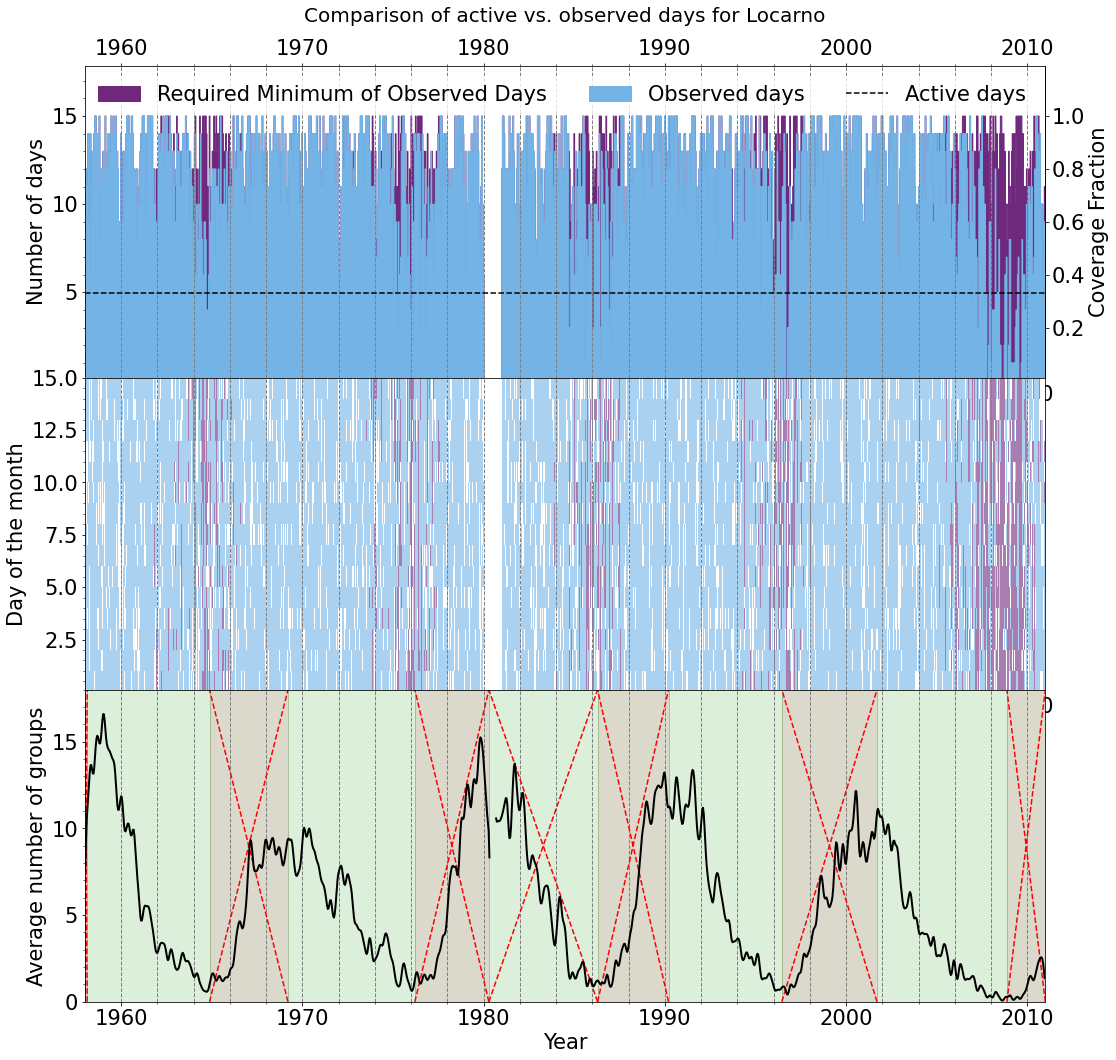

In [33]:
# Observer Plot
# Stack horizontal left ends to level the step-wise plot
pltxOb = np.stack((fyr1Ob,fyr1Ob)).reshape((1,-1),order='F')

# Append max fracyear to clapm aria
pltxOb = np.append(pltxOb,np.max(fyr2Ob))
pltxOb = np.append(pltxOb,np.max(fyr2Ob))

# Stack duplicate array to level the step-wise plot 
pltyOb = np.stack((obsOb,obsOb)).reshape((1,-1),order='F')
pltyGr = np.stack((grpOb,grpOb)).reshape((1,-1),order='F')
pltyAvOb = np.stack((AvGrpOb,AvGrpOb)).reshape((1,-1),order='F')
pltySd = np.stack((SdGrpOb,SdGrpOb)).reshape((1,-1),order='F')

# Append zeros to clamp area
pltyOb = np.insert(pltyOb,0,0)
pltyOb = np.append(pltyOb,0)

pltyGr = np.insert(pltyGr,0,0)
pltyGr = np.append(pltyGr,0)

pltyAvOb = np.insert(pltyAvOb,0,0)
pltyAvOb = np.append(pltyAvOb,0)

pltySd = np.insert(pltySd,0,0)
pltySd = np.append(pltySd,0)

plt.rc('font', **font)

# Size definitions
dpi = 300
pxx = 4000   # Horizontal size of each panel
pxy = 1300    # Vertical size of each panel

nph = 1      # Number of horizontal panels
npv = 3      # Number of vertical panels

# Padding
padv  = 50 #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 50 #Horizontal padding in pixels at the edge of the figure
padh2 = 0 #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )          #Horizontal size of figure in inches

# Conversion to relative unites
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units



## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi))

# Dummy axis for right scale
axd = fig.add_axes([ppadh, ppadv + 2*pxy/fszv, pxx/fszh, pxy/fszv])
axd.set_ylim(bottom = 0.01, top = 1.19)
axd.set_ylabel('Coverage Fraction')
axd.yaxis.set_label_position("right")
axd.yaxis.tick_right()


# Days with observations and active days
ax1 = fig.add_axes([ppadh, ppadv + 2*pxy/fszv, pxx/fszh, pxy/fszv], sharex=axd)
# Add number of days with observations
ax1.fill(pltxOb, pltyOb, color = Clr[2])
ax1.fill(pltxOb, pltyGr, color = Clr[4])
# Add number of days with groups (not including zeros and days without observations)

ax1.plot(np.array([np.min(pltxOb),np.max(pltxOb)]), np.array([1,1])*minObD*MoLngt, 'k--')



# Axes properties
ax1.text(0.5, 1.14,'Comparison of active vs. observed days for ' + NamObs.capitalize(), horizontalalignment='center',
         fontsize=20,
         transform = ax1.transAxes)
ax1.set_ylabel('Number of days')
ax1.legend(['Required Minimum of Observed Days','Observed days','Active days'], loc = 'upper right', ncol = 3, frameon = True, edgecolor = 'none')
ax1.set_xlim(left = np.min(fyr1Ob), right = np.max(fyr2Ob))
ax1.set_ylim(bottom = 0.01*MoLngt, top = 1.19*MoLngt)
ax1.grid(color=(0.5,0.5,0.5), linestyle='--', linewidth=1, axis='x', which='both')
ax1.xaxis.tick_top()
ax1.minorticks_on()

# Active/observation/missing mesh
AcObMesh = np.isfinite(grpsOb).astype(int)+np.greater(grpsOb,0).astype(int)
xMesh = np.insert(fyr2Ob,0,fyr1Ob[0])
yMesh = np.arange(0,MoLngt+1)

#Colormap
colors = [(1, 1, 1), Clr[2], Clr[4]]
cmap = clrs.LinearSegmentedColormap.from_list('cmap', colors, N=3)

ax2 = fig.add_axes([ppadh, ppadv + pxy/fszv, pxx/fszh, pxy/fszv], sharex=axd)
ax2.pcolormesh(xMesh, yMesh, np.transpose(AcObMesh), cmap = cmap, alpha = 0.6, linewidth = 2)
ax2.set_ylim(bottom = 0.1, top = MoLngt)

# Axes properties
ax2.set_ylabel('Day of the month')
ax2.grid(color=(0.5,0.5,0.5), linestyle='--', linewidth=1, axis='x', which='both')
ax2.minorticks_on()

# Average group number
ax3 = fig.add_axes([ppadh, ppadv, pxx/fszh, pxy/fszv])

for Idx in range(0,cenPoints.shape[0]):
    if vldIntr[Idx]:
        ax3.fill([endPoints[Idx, 0], endPoints[Idx, 0], endPoints[Idx+1, 0], endPoints[Idx+1, 0]], [0, np.ceil(np.nanmax(AvGrpOb))+1, np.ceil(np.nanmax(AvGrpOb))+1, 0 ], color = Clr[1+np.mod(Idx,2)*2], alpha = 0.2)
        if np.isnan(vldIntr[Idx]):
            ax3.plot([endPoints[Idx, 0], endPoints[Idx+1, 0]], [0, np.ceil(np.nanmax(AvGrpOb))+1], color = 'r', linestyle='--')
            ax3.plot([endPoints[Idx+1, 0], endPoints[Idx, 0]], [0, np.ceil(np.nanmax(AvGrpOb))+1], color = 'r', linestyle='--')

            ##### Removing interval from pool
            vldIntr[Idx] = 0
        
        
ax3.plot((fyr1Ob+fyr2Ob)/2, AvGrpOb, color = Clr[0], linewidth = 2)



# Axes properties
ax3.set_xlabel('Year')
ax3.set_ylabel('Average number of groups')
ax3.set_xlim(left = np.min(fyr1Ob), right = np.max(fyr2Ob))
ax3.grid(color=(0.5,0.5,0.5), linestyle='--', linewidth=1, axis='x', which='both')
ax3.minorticks_on()
ax3.set_ylim(bottom = 0, top = np.ceil(np.nanmax(AvGrpOb))+1);

**FIGURE:** _Top:_ Number of active (non-zero; blue) and observed (purple) days during each month.

_Middle:_ Grid showing each day during the observed period as no-data (white), no groups (purple), and active (blue).  The vertical axis denotes the day of the month and the horizontal axis the edges of each month.

_Bottom:_ Average number of groups each month.  Shaded areas indicate the separation of observations in sub-domains roughly going from maximum to maximum.  **White intervals are not used in calibration due to the interval being too small or not having good coverage**

<a id='#parameters'></a>
## Calculating the solar minimum masks that will be used in the optimization scan for best match

Given that our objective is to calculate the relative of different cycles we can take advantage of our knowledge of cycle progression to narrow the search for an optimum.  To do this we create a mask of valid search periods determined by using a window centered on the minima contained within the reference data.

In [34]:
# Temporal Stride in days
dt = 10

# Cycle phase tolerance in years
phTol = 2

# Creating window masks
risMask = np.zeros(REF_Grp.shape[0], dtype=bool)
decMask = np.zeros(REF_Grp.shape[0], dtype=bool)

# Applying mask
for cen in cenPointsR:
    if cen[1]==1:  
        risMask[np.logical_and(REF_Grp['FRACYEAR'].values>=cen[0]-phTol,REF_Grp['FRACYEAR'].values<=cen[0]+phTol)] = True
    else:
        decMask[np.logical_and(REF_Grp['FRACYEAR'].values>=cen[0]-phTol,REF_Grp['FRACYEAR'].values<=cen[0]+phTol)] = True
        
# Creating cadence mask
cadMask = np.zeros(REF_Grp.shape[0], dtype=bool)
cadMask[range(0,cadMask.shape[0],dt)] = True

# Removing early cycles
# cadMask[REF_Grp['FRACYEAR'].values<1900] = False

#Storing maks for plotting
risMaskP = risMask.copy()
decMaskP = decMask.copy()

# Creating rising mask
risMask = np.logical_and(cadMask,risMask)

# Creating decaying mask
decMask = np.logical_and(cadMask,decMask)

# Turnings Mask into indices
risMaskI = np.array(risMask.nonzero()[0])
decMaskI = np.array(decMask.nonzero()[0])

## Plotting maxima, minima, and search windows

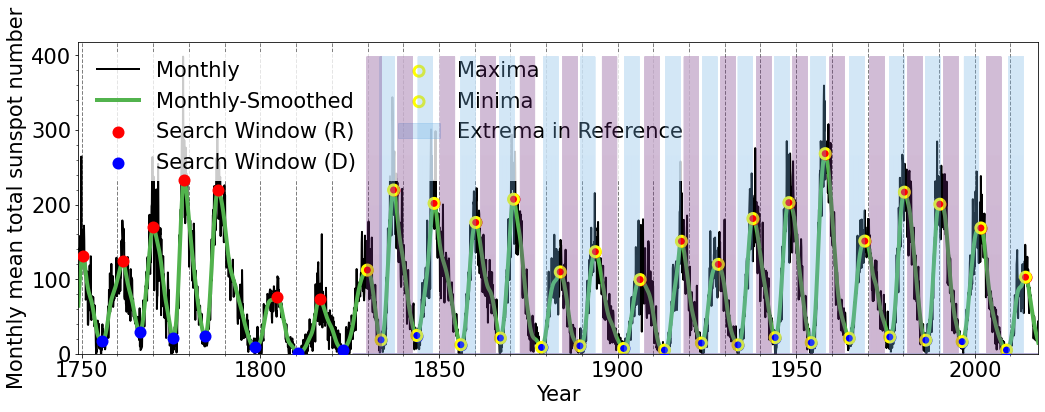

In [35]:
# Size definitions
dpi = 300
pxx = 4000   # Horizontal size of each panel
pxy = 1300    # Vertical size of each panel

nph = 1      # Number of horizontal panels
npv = 1      # Number of vertical panels

# Padding
padv  = 50 #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 50 #Horizontal padding in pixels at the edge of the figure
padh2 = 0 #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in inches

# Conversion to relative unites
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi))


# Average group number 
ax1 = fig.add_axes([ppadh, ppadv, pxx/fszh, pxy/fszv])
ax1.plot(SILSO_Sn['FRACYEAR'], SILSO_Sn['MMEAN'], color = Clr[0], linewidth = 2)
ax1.plot(SILSO_Sn['FRACYEAR'], SILSO_Sn['MSMOOTH'], color = Clr[3], linewidth = 4)
ax1.scatter(SIL_maxT, SIL_max, color='r', edgecolor='r', alpha = 1, s=100, linewidths = 2, zorder=10)
ax1.scatter(SIL_minT, SIL_min, color='b', edgecolor='b', alpha = 1, s=100, linewidths = 2, zorder=10)
ax1.scatter(REF_minT, REF_min, color='none', edgecolor='yellow', alpha = 1, s=100, linewidths = 3, zorder=10)
ax1.scatter(REF_maxT, REF_max, color='none', edgecolor='yellow', alpha = 1, s=100, linewidths = 3, zorder=10)
ax1.fill(REF_Grp['FRACYEAR'],  risMask*np.max(SILSO_Sn['MMEAN']), edgecolor = Clr[4], color = Clr[4], alpha = 0.3, zorder=15)
ax1.fill(REF_Grp['FRACYEAR'],  decMask*np.max(SILSO_Sn['MMEAN']), edgecolor = Clr[2], color = Clr[2], alpha = 0.3, zorder=15)


ax1.legend(['Monthly','Monthly-Smoothed','Search Window (R)','Search Window (D)','Maxima', 'Minima','Extrema in Reference'], loc = 'upper left', ncol = 2, frameon = True, edgecolor = 'none')

# Axes properties
ax1.set_xlabel('Year')
ax1.set_ylabel('Monthly mean total sunspot number')
ax1.set_xlim(left = np.min(SILSO_Sn['FRACYEAR']), right = np.max(SILSO_Sn['FRACYEAR']))
ax1.grid(color=(0.5,0.5,0.5), linestyle='--', linewidth=1, axis='x', which='both')
ax1.minorticks_on()
ax1.set_ylim(bottom = 0);

**FIGURE:** Maxima and minima determinid using SILSO's v2 series.  This help us reduce significantly the number of steps on the optimization scan.  This way, rising (decaying) phases of the observer only need to be compared with rising (decaying) phasis of the reference

# Calculating the optimal threshold for low, medium, and high solar activity

/tmp/ipykernel_3919/4008504587.py:30: RuntimeWarning: invalid value encountered in true_divide
  ADFREF = GDREF/ODREF


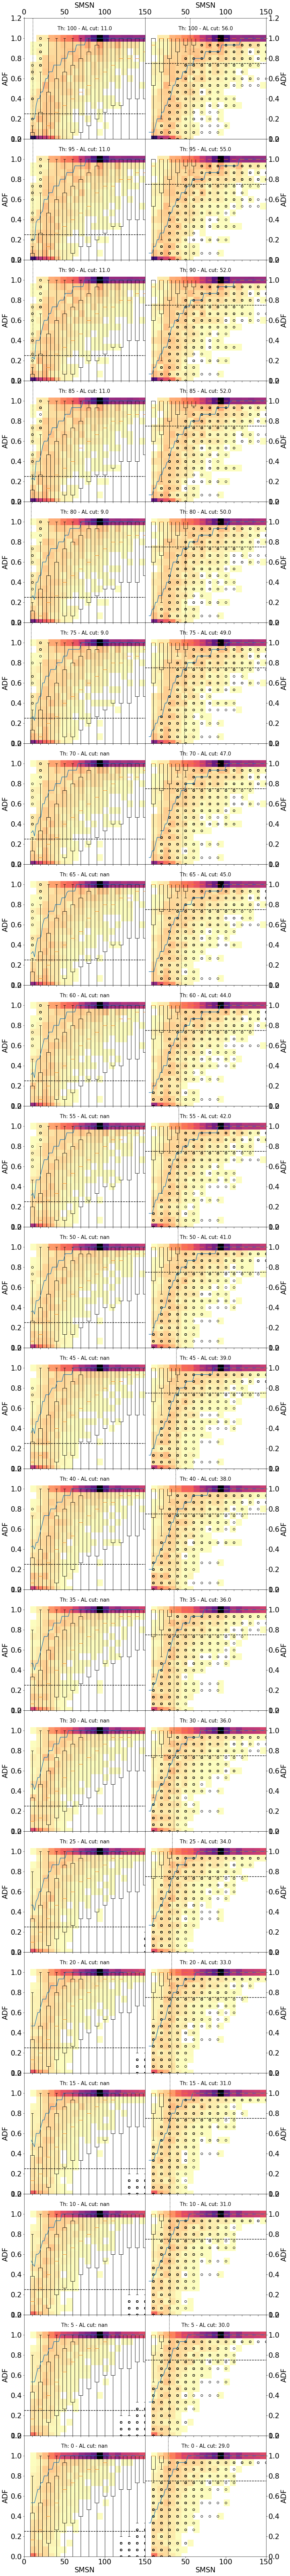

In [37]:
thN = 21  # Number of thresholds to plot
thS = 5  # Threshold increment
pctllow = 85  # Percentile to define low solar activity level
pctlhigh = 90 # Percentile to define high solar activity level

# creating matrix to define thresholds
TREFDat = REF_Grp['GROUPS'].values.copy()
TREFSNd = REF_Grp['AVGSNd'].values.copy()

GDREF = np.zeros((thN,int(TREFDat.shape[0]/MoLngt)))
ODREF = np.zeros((thN,int(TREFDat.shape[0]/MoLngt)))
SNdREF = np.zeros((thN,int(TREFDat.shape[0]/MoLngt)))

for TIdx in range(0,thN):
    
    grpsREFw = np.nansum( np.greater(REF_Dat.values[:,3:REF_Dat.values.shape[1]-3],TIdx*thS) ,axis = 1).astype(float)
    grpsREFw[np.isnan(REF_Dat['AREA1'])] = np.nan

    TgrpsREF = grpsREFw[0:int(grpsREFw.shape[0]/MoLngt)*MoLngt].copy()
    TgrpsREF = TgrpsREF.reshape((-1,MoLngt))            
    TSNdREF = TREFSNd[0:int(TREFSNd.shape[0]/MoLngt)*MoLngt].copy()
    TSNdREF = TSNdREF.reshape((-1,MoLngt))            
    # Number of days with groups
    GDREF[TIdx,:] = np.sum(np.greater(TgrpsREF,0),axis=1)
    # Number of days with observations
    ODREF[TIdx,:]= np.sum(np.isfinite(TgrpsREF),axis=1)            
    # Number of quiet days
    QDREF = ODREF-GDREF
    # ACTIVE DAY FRACTION
    ADFREF = GDREF/ODREF
    # Monthly sunspot number
    SNdREF[TIdx,:]=np.mean(TSNdREF,axis=1) 


# Plotting threshold           
plt.rc('font', **font)

# Size definitions
dpi = 300
pxx = 1500   # Horizontal size of each panel
pxy = pxx    # Vertical size of each panel

nph = 2      # Number of horizontal panels
npv = thN    # Number of vertical panels

# Padding
padv  = 50 #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 50 #Horizontal padding in pixels at the edge of the figure
padh2 = 0  #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in inches

# Conversion to relative unites
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units

Nbinsx = 20
Nbinsy = 20

edgesx = np.arange(0,Nbinsy+1)/Nbinsy*150
edgesy = np.arange(0,Nbinsy+1)/Nbinsy
edgesy = (np.arange(0,MoLngt+2) - 0.5)/MoLngt


bprange = np.arange(10,175,10)
pprange = np.arange(5,175,2)

## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi))

LowALlim = np.zeros(thN)
HighALlim = np.zeros(thN)

for n in range(0,thN):

    pltmsk = ODREF[n,:]==MoLngt

    #ax1
    ax1 = fig.add_axes([ppadh, ppadv+n*pxy/fszv, pxx/fszh, pxy/fszv], label= 'b1')
    ax1.hist2d(SNdREF[n,:][pltmsk], ADFREF[n,:][pltmsk], bins=[edgesx,edgesy], cmap=plt.cm.magma_r,cmin=1) 

    bpdat = []    
    for AL in bprange:
        bpdat.append(ADFREF[n,:][np.logical_and(pltmsk, SNdREF[n,:]<=AL)])

    ax1.boxplot(bpdat, positions=bprange, widths=5)

    ALP = pprange*np.nan
    for ALi in np.arange(0,pprange.shape[0]):
        if (np.sum(np.logical_and(pltmsk, SNdREF[n,:]<=pprange[ALi]))>0):ALP[ALi] = np.percentile(ADFREF[n,:][np.logical_and(pltmsk, SNdREF[n,:]<=pprange[ALi])], pctllow)

    ax1.plot(pprange, ALP)
    ax1.plot([0,150],[0.25,0.25],color='k',linestyle='--')

    intrsc = np.where(np.abs(ALP-0.25)==np.nanmin(np.abs(ALP-0.25)))[0]
    cut = np.mean(pprange[intrsc])        
    if np.sum(ALP<0.25)==0:
        cut = np.nan

    LowALlim[n] = cut          

    ax1.plot([cut,cut],[0,1.2],color='k',linestyle=':')

    # Axes properties
    ax1.text(0.5, 0.9,'Th: ' + str(n*thS) + ' - AL cut: ' + str(cut), horizontalalignment='center',fontsize=15,transform = ax1.transAxes)
    ax1.set_ylabel('ADF')
    ax1.set_ylim(top=1.2,bottom=0)
    ax1.set_xlim(left = 0, right=150)    


    #ax2
    ax2 = fig.add_axes([ppadh+pxx/fszh, ppadv+n*pxy/fszv, pxx/fszh, pxy/fszv], label= 'b2')
    ax2.hist2d(SNdREF[n,:][pltmsk], ADFREF[n,:][pltmsk], bins=[edgesx,edgesy], cmap=plt.cm.magma_r,cmin=1)

    bpdat = []
    for AL in bprange:        
        bpdat.append(ADFREF[n,:][np.logical_and(pltmsk, SNdREF[n,:]>=AL)])

    ax2.boxplot(bpdat, positions=bprange, widths=5)

    ALP = pprange*np.nan
    for ALi in np.arange(0,pprange.shape[0]):
        if (np.sum(np.logical_and(pltmsk, SNdREF[n,:]>=pprange[ALi]))>0):ALP[ALi] = np.percentile(ADFREF[n,:][np.logical_and(pltmsk, SNdREF[n,:]>=pprange[ALi])], 100-pctlhigh)

    ax2.plot(pprange, ALP)
    ax2.plot([0,150],[0.75,0.75],color='k',linestyle='--')

    intrsc = np.where(np.abs(ALP-0.75)==np.nanmin(np.abs(ALP-0.75)))[0]
    cut = np.mean(pprange[intrsc])
    if np.sum(ALP<0.75)==0:
        cut = np.nan

    HighALlim[n] = cut            

    ax2.plot([cut,cut],[0,1.2],color='k',linestyle=':')            

    # Axes properties
    ax2.set_ylabel('ADF')
    ax2.yaxis.set_label_position("right")
    ax2.text(0.5, 0.9,'Th: ' + str(n*thS) + ' - AL cut: ' + str(cut), horizontalalignment='center',fontsize=15,transform = ax2.transAxes)
    ax2.set_ylim(top=1.2,bottom=0)

    ax2.yaxis.tick_right()
    ax2.set_xlim(left = 0, right=150)

    if n>0&n<thN-1:
        ax1.set_xticklabels([])
        ax2.set_xticklabels([])        
    else:
        ax1.set_xlabel('SMSN')
        ax2.set_xlabel('SMSN')
        ax1.set_xticks([0,50,100,150])
        ax1.set_xticklabels([0,50,100,150])
        ax2.set_xticks([50,100,150])
        ax2.set_xticklabels([50,100,150])

    if n==thN-1:
        ax1.xaxis.set_label_position("top")
        ax1.xaxis.tick_top()
        ax2.xaxis.tick_top()
        ax2.xaxis.set_label_position("top")
        ax1.set_xlabel('SMSN')
        ax2.set_xlabel('SMSN')
        ax1.set_xticks([0,50,100,150])
        ax1.set_xticklabels([0,50,100,150])
        ax2.set_xticks([50,100,150])
        ax2.set_xticklabels([50,100,150])

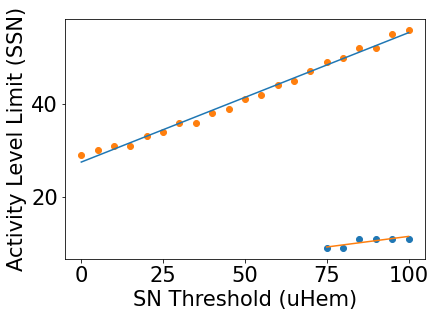

In [38]:
# fit for low solar activity
xlow = np.arange(0,thN)*thS
xlow = xlow[np.isfinite(LowALlim)]
ylow = LowALlim[np.isfinite(LowALlim)]
fitlow = np.polyfit(xlow,ylow,deg=1)
a1low = fitlow[0]
a0low = fitlow[1]

# fit for high solar activity
xhigh = np.arange(0,thN)*thS
xhigh = xhigh[np.isfinite(HighALlim)]
yhigh = HighALlim[np.isfinite(HighALlim)]
fithigh = np.polyfit(xhigh,yhigh,deg=1)
a1high = fithigh[0]
a0high = fithigh[1]


plt.rc('font', **font)
    
# Size definitions
dpi = 300
pxx = 1500   # Horizontal size of each panel
pxy = 1000   # Vertical size of each panel

nph = 1      # Number of horizontal panels
npv = 1      # Number of vertical panels

# Padding
padv  = 50 #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 50 #Horizontal padding in pixels at the edge of the figure
padh2 = 0  #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in inches

# Conversion to relative unites
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units

## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi))
ax1 = fig.add_axes([ppadh, ppadv, pxx/fszh, pxy/fszv])

ax1.scatter(xlow, ylow, alpha=1)
ax1.scatter(xhigh, yhigh,alpha=1)
ax1.plot(xhigh,fithigh[0]*xhigh+fithigh[1])
ax1.plot(xlow,fitlow[0]*xlow+fitlow[1])

ax1.set_xlabel('SN Threshold (uHem)')
ax1.set_ylabel('Activity Level Limit (SSN)');
